# Cognition & Computation - Lab 1

To start with, let's download some scripts from a GitHub repository that implement a DBN in PyTorch.

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import torch
import torchvision as tv

from DBN import DBN

Then, let's download the EMNIST dataset instead of MNIST.

In [4]:
%%capture
emnist_data = tv.datasets.EMNIST('data/', 'balanced' , train=True, download=True,
                                        transform=tv.transforms.Compose(
                                            [tv.transforms.ToTensor(),
                                             tv.transforms.Normalize((0.1307,), (0.3081,))]
                                        ))

In [5]:
emnist_data.data = (emnist_data.data.type(torch.FloatTensor)/255)

The number shown is the number: 42


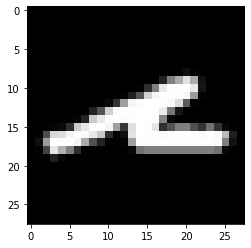

In [6]:
idx = 5
img = emnist_data.data[idx]
print("The number shown is the number: {}".format(emnist_data.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

Let's create a training set and a test set, which we will use later:

In [7]:
emnist_data_train = emnist_data.data[10000:, :]
emnist_targets_train = emnist_data.targets[10000:]

emnist_data_test = emnist_data.data[:10000, :]
emnist_targets_test = emnist_data.targets[:10000]

## Training a DBN
Quick recall from the theory: 
- a Deep Belief Network is a stack of Restricted Boltzmann Machines, another kind of energy-based model;
- they are *unsupervised* deep learning architectures that learn a probability distribution that could have generated the training data;
- this means they can be used to run both forwards and backwards passes through the architecture, to compute either hidden representations, or "prototypical" examples of a class based on the learned probability distributions;
- they are trained using an algorithm called *contrastive divergence*, whose goal is to reduce the difference between the learned probability distribution and the true one.

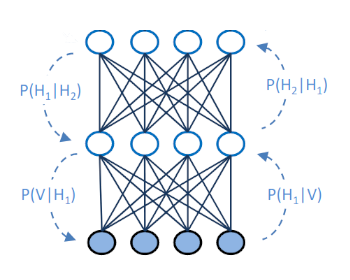

In [8]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500, 500],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=False,
                increase_to_cd_k=False,
                # use_gpu=False)
                use_gpu=True)

Let's train the network:

In [9]:
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0323   |0.0344   |325.3542 |5.9536   |
|20    |0.9798   |0.0312   |303.8902 |5.2745   |
|30    |0.9614   |0.0309   |296.4953 |5.2261   |
|40    |0.9540   |0.0309   |293.8921 |5.4104   |
|50    |0.9499   |0.0301   |291.9235 |5.0903   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0878   |0.0329   |223.3972 |3.5632   |
|20    |1.0271   |0.0307   |215.9721 |3.0544   |
|30    |1.0155   |0.0301   |214.4051 |3.1361   |
|40    |1.0100   |0.0299   |214.5713 |3.0763   |
|50    |1.0059   |0.0291   |212.5604 |3.0945   |


## Visualizing receptive fields

After training the network, we are now going to visualize the learned weights. In order to do so, we will plot some of the weights in a picture of the same size of the MNIST images we used for training. In this way, we will see what parts of an image trigger the unit represented by a specific weight vector.

It will also be useful to apply a threshold on the learned weights, in order to make the plots less noisy.

In [10]:
def _move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [12]:
_move_parameters_to_cpu(dbn_emnist)

In [13]:
def _apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def _plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

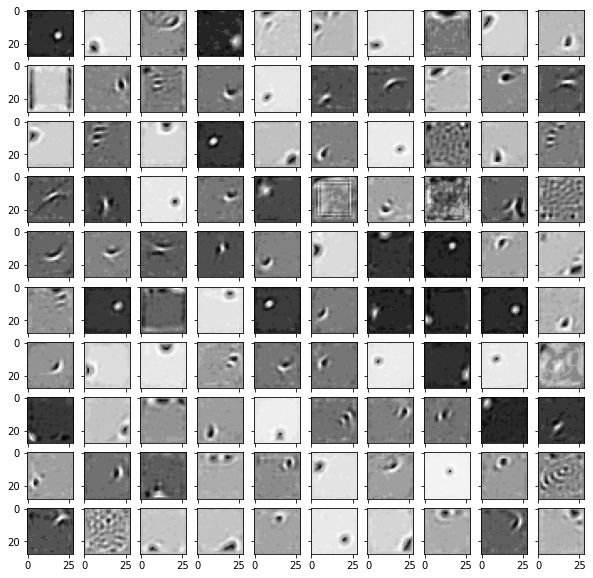

In [14]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)

_plot_layer_receptive_fields(learned_weights_layer_1)

The weights in the second hidden layer have dimensionality `(529, 324)`, i.e. they are vectors of `324` elements associated to each of the `529` nodes of the first layer. Therefore, we will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images.

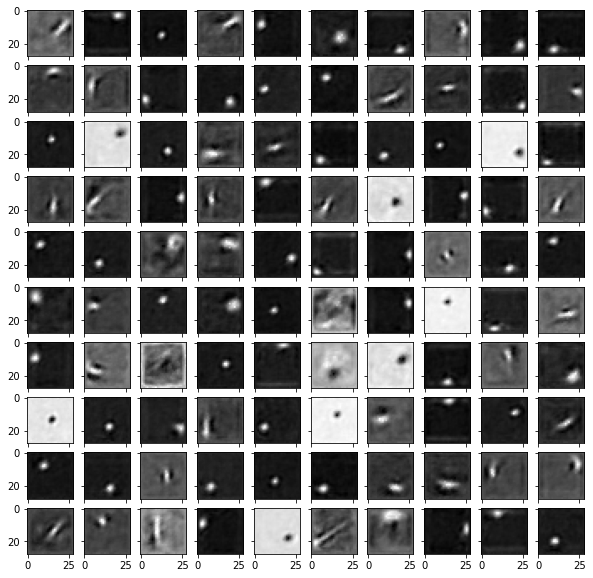

In [15]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()

learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)

_plot_layer_receptive_fields(learned_weights_product)

## Clustering internal representations

Then, we want to examine the properties of the learned representations. Therefore, we will compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.

This implementation of the `DBN` contains internally several `RBM` objects. Therefore, we will need to compute the hidden representation using the weights of each `RBM` contained in the `DBN`.

In [16]:
def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

Of course, the representations computed using the second layer receive as input those of the first one:

In [17]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [20]:
def _get_mask(label):  # we use this function to filter by class
  labels = emnist_targets_train.numpy()
  return labels == label

def _get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.numpy()
  return {
    label: hidden_representation_np[_get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):  # we use this to build the matrices
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [21]:
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)

In [22]:
mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [23]:
def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

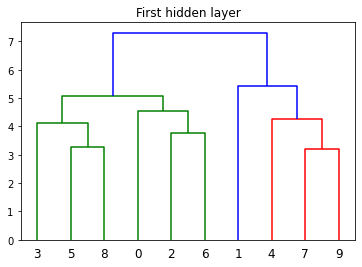

In [24]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

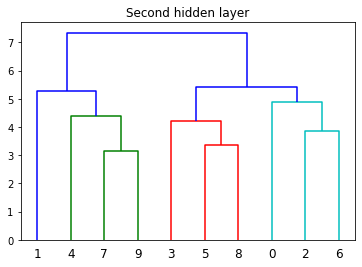

In [25]:
_plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

## Linear read-out

In [31]:
last_layer_size = dbn_emnist.rbm_layers[-1].W.shape[0]

class Perceptron(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(last_layer_size, 47) # changed to EMNIST Balanced number of classes 47

  def forward(self, x):
    return self.linear(x)

In [32]:
perceptron = Perceptron()

In [33]:
optimizer = torch.optim.SGD(perceptron.parameters(), lr=0.05)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 1000

for epoch in range(epochs):
  optimizer.zero_grad()
  predictions = perceptron(hidden_repr_layer_2).squeeze()
  targets = emnist_targets_train.reshape(predictions.shape[0])
  loss = loss_fn(predictions, targets)
  loss.backward()
  optimizer.step()

  print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/1000, loss = 3.906347
epoch : 2/1000, loss = 3.893132
epoch : 3/1000, loss = 3.880067
epoch : 4/1000, loss = 3.867141
epoch : 5/1000, loss = 3.854351
epoch : 6/1000, loss = 3.841689
epoch : 7/1000, loss = 3.829149
epoch : 8/1000, loss = 3.816727
epoch : 9/1000, loss = 3.804418
epoch : 10/1000, loss = 3.792217
epoch : 11/1000, loss = 3.780121
epoch : 12/1000, loss = 3.768126
epoch : 13/1000, loss = 3.756229
epoch : 14/1000, loss = 3.744427
epoch : 15/1000, loss = 3.732715
epoch : 16/1000, loss = 3.721094
epoch : 17/1000, loss = 3.709558
epoch : 18/1000, loss = 3.698107
epoch : 19/1000, loss = 3.686738
epoch : 20/1000, loss = 3.675449
epoch : 21/1000, loss = 3.664237
epoch : 22/1000, loss = 3.653103
epoch : 23/1000, loss = 3.642043
epoch : 24/1000, loss = 3.631056
epoch : 25/1000, loss = 3.620141
epoch : 26/1000, loss = 3.609296
epoch : 27/1000, loss = 3.598521
epoch : 28/1000, loss = 3.587812
epoch : 29/1000, loss = 3.577172
epoch : 30/1000, loss = 3.566596
epoch : 31/1000, lo

Let's now build the representation for the test set we kept apart at the beginning:

In [34]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)

In [35]:
predictions_test = perceptron(hidden_repr_layer_2_test)

In [39]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == emnist_targets_test).sum() / len(emnist_targets_test)
  return accuracy.item()

In [40]:
_compute_accuracy(predictions_test, emnist_targets_test)

0.6304000020027161

## Reference papers
- [Reducing the Dimensionality of Data with Neural Networks](https://www.science.org/doi/10.1126/science.1127647)
- [Deep unsupervised learning on a desktop PC: a primer for cognitive scientists](https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00251/full)
- [Training restricted Boltzmann machines: An introduction](https://www.sciencedirect.com/science/article/pii/S0031320313002495)

## Contacts

- 📧 flavio.petruzzellis@phd.unipd.it
- 💬 [Moodle forum](https://elearning.unipd.it/math/mod/forum/view.php?id=36439)